---
authors: Chinming Zhu
updated: December 3, 2025
---

# Is het verdamping?

In dit experiment is er een verwarmingselement in een met water gevulde maatbeker gestopt. Elke minuut is de temperatuur van het water gemeten. Deze metingen zijn opgeslagen in [tempmetingen.csv](tempmetingen.csv).

Verder is gegeven dat: 
$m_{maatbeker} = 820.8 \mathrm{gr}$  
$m_{maatbeker + water, start} = 1292.9 \mathrm{gr}$  
$m_{maatbeker + water, eind} = 1274.9 \mathrm{gr}$

Het moge duidelijk zijn dat er water is 'verdwenen'. Ook is de eindtemperatuur van het water niet gelijk aan een proces waarbij verdamping en eventuele warmteverliezen niet meegenomen worden. 

```{exercise}
Onderzoek het proces door:
1. De plot van de metingen te maken, inclusief een verwachte trendlijn voor de temperatuur van het water als al de toegevoerde warmte gaat zitten in het water.
2. Bepaal of de totale hoeveelheid toegevoegde energie correspondeert met de opwarming en verdamping van het water, geef daarbij de aannames die je doet.
3. Geef aanbevelingen voor een verbetering van het experiment om (nog) beter het thermodynamische proces te kunnen onderzoeken en beschrijven.
```

Geschat vermogen uit eerste 10 min: P ≈ 44.7 W
Gebruikt vermogen voor de verwachting:      P_input = 44.7 W
Tijd tot 100°C (als alles in het water gaat): ~57.9 min


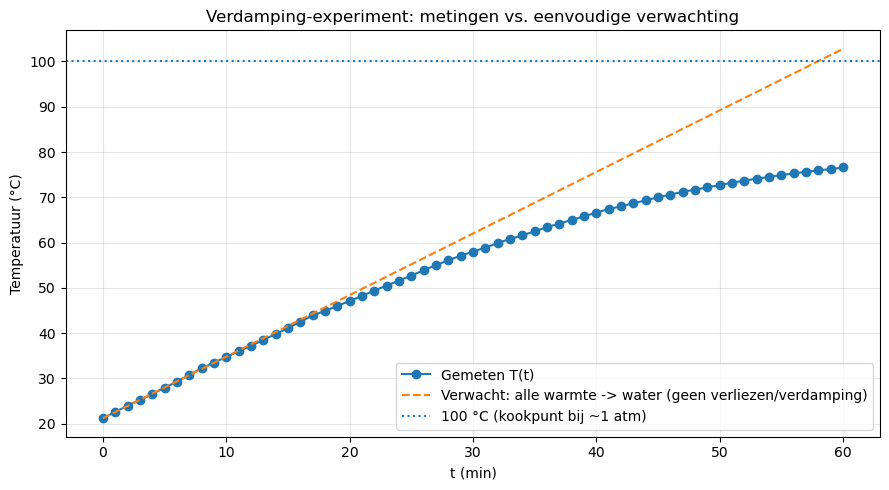

In [1]:
# Imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#  Data inlezen 
default_file = Path("tempmetingen.csv")
if default_file.exists():
    data_file = default_file
else:
    # zoek naar een csv die met 'tempmetingen' begint
    matches = sorted(Path(".").glob("tempmetingen*.csv"))
    if not matches:
        raise FileNotFoundError("Geen tempmetingen*.csv gevonden. Zet het CSV-bestand in dezelfde map als deze notebook.")
    data_file = matches[0]

df = pd.read_csv(data_file, sep=";")
df.columns = [c.strip() for c in df.columns]  # kleine opschoning

# tijd in minuten en seconden
t_min = df["t (min)"].to_numpy()
t_s = 60 * t_min

# temperatuur in °C (verschillen in °C == verschillen in K)
T = df["t (oC)"].to_numpy()
T0 = float(T[0])

#  Gegeven massa's 
m_maatbeker_g = 820.8
m_maatbeker_water_start_g = 1292.9
m_maatbeker_water_eind_g = 1274.9

m_water_start = (m_maatbeker_water_start_g - m_maatbeker_g) / 1000  # kg
m_water_eind  = (m_maatbeker_water_eind_g  - m_maatbeker_g) / 1000  # kg

#  Verwachte trendlijn (alle toegevoerde warmte -> water) 
cp_water = 4180  # J/(kg*K), benadering

# Omdat het elektrische vermogen niet in de opgave staat, schatten we het uit het beginstuk
# (waar verdamping en verliezen relatief klein zijn) via een lineaire fit.
fit_minutes = 10
mask = t_min <= fit_minutes
A = np.vstack([t_s[mask], np.ones(mask.sum())]).T
slope, intercept = np.linalg.lstsq(A, T[mask], rcond=None)[0]  # T ~ slope*t + intercept

P_est = m_water_start * cp_water * slope  # W (J/s)

# Als jij wél U en I gemeten hebt, vul dan hieronder je eigen vermogen in, bijv.:
# P_input = U * I
P_input = P_est

T_expected = T0 + (P_input / (m_water_start * cp_water)) * t_s

# Extra: tijd tot 100°C volgens dit eenvoudige model
t_to_100_s = (100 - T0) * (m_water_start * cp_water) / P_input
t_to_100_min = t_to_100_s / 60

print(f"Geschat vermogen uit eerste {fit_minutes} min: P ≈ {P_est:.1f} W")
print(f"Gebruikt vermogen voor de verwachting:      P_input = {P_input:.1f} W")
print(f"Tijd tot 100°C (als alles in het water gaat): ~{t_to_100_min:.1f} min")

#  Plot 
plt.figure(figsize=(9, 5))
plt.plot(t_min, T, "o-", label="Gemeten T(t)")
plt.plot(t_min, T_expected, "--", label="Verwacht: alle warmte -> water (geen verliezen/verdamping)")
plt.axhline(100, linestyle=":", label="100 °C (kookpunt bij ~1 atm)")
plt.xlabel("t (min)")
plt.ylabel("Temperatuur (°C)")
plt.title("Verdamping-experiment: metingen vs. eenvoudige verwachting")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()


In [2]:
import numpy as np

#  Energie-balans 
t_total_s = float(t_s[-1] - t_s[0])

m_evap = m_water_start - m_water_eind  # kg verdampt (uit massaverschil)
T_end = float(T[-1])
dT = T_end - T0

Q_in = P_input * t_total_s  # J

# Benader latente verdampingswarmte (water) als functie van temperatuur:
# h_fg(T) ≈ 2500.9 - 2.36*T  [kJ/kg], geldig grofweg voor 0–100°C
h_fg_kJ_per_kg = 2500.9 - 2.36 * T_end
h_fg = h_fg_kJ_per_kg * 1000  # J/kg

# Energie om water op te warmen:
# - resterende massa: van T0 naar T_end
# - verdampte massa: ook eerst opwarmen van T0 naar (ongeveer) T_end
Q_sens = (m_water_eind + m_evap) * cp_water * dT  # dit is gelijk aan m_water_start*cp*dT
Q_lat = m_evap * h_fg

Q_need_water = Q_sens + Q_lat
Q_diff = Q_in - Q_need_water

# Wat zou de eindtemperatuur zijn zonder verdamping/verliezen?
T_end_if_all_into_water = T0 + Q_in / (m_water_start * cp_water)

print(" Massa's ")
print(f"m_water_start = {m_water_start*1000:.1f} g")
print(f"m_water_eind  = {m_water_eind*1000:.1f} g")
print(f"m_verdampt    = {m_evap*1000:.1f} g")

print("\n Temperatuur ")
print(f"T_start = {T0:.1f} °C")
print(f"T_eind  = {T_end:.1f} °C")
print(f"ΔT      = {dT:.1f} K")

print("\n Energie (met aannames hieronder) ")
print(f"Ingevoerde energie (Q_in)                 ≈ {Q_in/1000:.1f} kJ")
print(f"Opwarming water (Q_sens = m*c*ΔT)         ≈ {Q_sens/1000:.1f} kJ")
print(f"Latente verdamping (Q_lat = m*h_fg)       ≈ {Q_lat/1000:.1f} kJ")
print(f"Totaal nodig voor water (Q_sens + Q_lat)  ≈ {Q_need_water/1000:.1f} kJ")
print(f"Verschil (Q_in - Q_need)                  ≈ {Q_diff/1000:.1f} kJ")

print("\n Interpretatie ")
print(f"Als alle energie in het water zou gaan (geen verdamping/verliezen), dan zou T_eind ≈ {T_end_if_all_into_water:.1f} °C zijn.")
if Q_diff > 0:
    print("Omdat Q_in > Q_need_water in deze benadering, blijft er energie over voor o.a. opwarming van de maatbeker, het element en warmteverlies naar de omgeving.")
else:
    print("Omdat Q_in < Q_need_water in deze benadering, is het gebruikte P_input waarschijnlijk te laag (of de aannames over h_fg / verdampingstemperatuur kloppen niet).")

# Aannames (kort):
# - water is goed gemengd -> overal dezelfde T
# - verdamping wordt benaderd alsof de verdampte massa bij ongeveer T_end is verdampt
# - h_fg benaderd met een eenvoudige formule (geen stoomtabellen)
# - warmtecapaciteit van maatbeker/element en verliezen zijn niet expliciet meegenomen


 Massa's 
m_water_start = 472.1 g
m_water_eind  = 454.1 g
m_verdampt    = 18.0 g

 Temperatuur 
T_start = 21.2 °C
T_eind  = 76.6 °C
ΔT      = 55.4 K

 Energie (met aannames hieronder) 
Ingevoerde energie (Q_in)                 ≈ 161.0 kJ
Opwarming water (Q_sens = m*c*ΔT)         ≈ 109.3 kJ
Latente verdamping (Q_lat = m*h_fg)       ≈ 41.8 kJ
Totaal nodig voor water (Q_sens + Q_lat)  ≈ 151.1 kJ
Verschil (Q_in - Q_need)                  ≈ 9.9 kJ

 Interpretatie 
Als alle energie in het water zou gaan (geen verdamping/verliezen), dan zou T_eind ≈ 102.8 °C zijn.
Omdat Q_in > Q_need_water in deze benadering, blijft er energie over voor o.a. opwarming van de maatbeker, het element en warmteverlies naar de omgeving.


## Conclusie en aanbevelingen

### 1) Plot + verwachte trendlijn
De grafiek laat de gemeten temperatuurstijging zien en een eenvoudige verwachting: **lineaire opwarming** als *alle* toegevoerde warmte in het water terechtkomt (dus zonder verdamping en zonder warmteverlies).

### 2) Komt de toegevoerde energie overeen met opwarming + verdamping?
Op basis van de massametingen is er ongeveer **18 g water verdampt**.  
Met een (ruwe) benadering voor de latente verdampingswarmte bij de eindtemperatuur en met $c_p \approx 4180\ \mathrm{J/(kg\,K)}$ kan je de benodigde energie voor:

- **opwarming** $Q_\mathrm{sens} = m\,c_p\,\Delta T$
- **verdamping** $Q_\mathrm{lat} = m_\mathrm{verdampt}\,h_{fg}$

uitrekenen en vergelijken met $Q_\mathrm{in}=P\,t$.

Omdat het elektrische vermogen niet in de opgave staat, is $P$ in de code **geschat uit de eerste ~10 minuten**.  
Dat geeft een *ondergrens*: al in het begin zijn er namelijk vaak al verliezen (naar de maatbeker en de lucht), waardoor de “echte” elektrische invoer groter kan zijn.

### 3) Verbeteringen aan het experiment
Concrete verbeteringen om het thermodynamische proces beter te onderzoeken:

- **Meet het elektrische vermogen** direct: spanning én stroom loggen (liefst continu) → $P(t)=U(t)\,I(t)$.
- **Roeren / mengen** (magneetroerder): maakt de watertemperatuur homogeen en voorkomt lokale oververhitting bij het element.
- **Isoleren** van de maatbeker (en afschermen tegen tocht): vermindert warmteverlies naar de omgeving.
- **Deksel + condenser/koeler**: vang verdampte waterdamp op en meet massaverlies nauwkeuriger (of voorkom verdamping als je alleen opwarming wilt).
- **Weeg tijdens het experiment** (continu of om de paar minuten): dan krijg je $m(t)$ in plaats van alleen begin/eind → betere energiebalans.
- **Neem de warmtecapaciteit** van maatbeker, element en thermometer mee (of kalibreer via een apart “calorimeter-constante” experiment).
- **Meet omgevingscondities**: luchttemperatuur, luchtstroming, (relatieve) vochtigheid beïnvloeden de verdampingssnelheid.

Als je de echte elektrische invoer en $m(t)$ hebt, kun je het proces veel strakker beschrijven met een tijdsafhankelijke energiebalans.
